# 03 | Plot Fan Curve

In [1]:
from opencefadb import OpenCeFaDB

In [2]:
WORKING_DIR = "local-db"

Select either `GraphDB` or `rdflib.Graph` (see [graphdb tutorial](graphdb.ipynb) for more)

In [3]:
USE_GRAPH_DB = True

if USE_GRAPH_DB:
    db = OpenCeFaDB.from_graphdb_setup(
        working_directory=WORKING_DIR,
        version="latest",
        endpoint="http://localhost:7200",
        repository="OpenCeFaDB-Sandbox",
        username="admin",
        password="admin",
        add_wikidata_store=False
    )
else:
    db = OpenCeFaDB.from_rdflib_setup(
        working_directory=WORKING_DIR,
        version="latest",
    )
    # db.download_metadata()  # only needs to be done once
    for ttl_filename in db.rdf_directory.rglob("*.ttl"):
        db.rdf_store.upload_file(ttl_filename)
    db.add_hdf_infile_index()

 [OpenCEFA DB]: Searching for the latest version...
 [OpenCEFA DB]: downloading version 1.0.0...
 [OpenCEFA DB]: Downloaded latest OpenCeFaDB config file to 'local-db\opencefadb-catalog-1-0-0.ttl'.
 [OpenCEFA DB]: Validating downloaded catalog against SHACL shapes...
 [OpenCEFA DB]: Catalog is valid.


You may download the files manually if the download fails:

In [4]:
base = "https://doi.org/10.5281/zenodo.17572275#standard_name_table/"

sn_mean_nrot = base + "derived_standard_name/arithmetic_mean_of_fan_rotational_speed"
sn_mean_dp_stat = base + "derived_standard_name/arithmetic_mean_of_difference_of_static_pressure_between_fan_outlet_and_fan_inlet"
sn_mean_dp_tot = base + "derived_standard_name/arithmetic_mean_of_difference_of_total_pressure_between_fan_outlet_and_fan_inlet"
sn_mean_vfr = base + "derived_standard_name/arithmetic_mean_of_fan_volume_flow_rate"
sn_mean_rho = base + "derived_standard_name/arithmetic_mean_of_air_density"

operating_point_standard_names = {
    sn_mean_dp_stat,
    sn_mean_dp_tot,
    sn_mean_vfr,
    sn_mean_nrot,
    sn_mean_rho
}

In [5]:
rotation_speeds = [600, 800, 1000]

observation_clusters = []
for rs in rotation_speeds:
    observations = db.get_operating_point_observations(
        n_rot_speed_rpm=rs,
        operating_point_standard_names=operating_point_standard_names,
        standard_name_of_rotational_speed=sn_mean_nrot,
        n_rot_tolerance=0.05 # 5 %
    )
    observation_clusters.append(observations)

Processing operating point datasets: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.46 datasets/s]


In [6]:
from opencefadb.models.fan_curve import SemanticFanCurve

from opencefadb import plotting
import matplotlib.pyplot as plt

In [7]:
fan_curves = [
    SemanticFanCurve.from_observations(
        observations=observations
    ) for observations in observation_clusters
]

The observations were made only close to a target revolutions speed. This is why we used `n_rot_tolerance` before. Now we scale every operation point of a collection to a reference one:

In [8]:
from ssnolib.m4i import NumericalVariable
from ontolutils.namespacelib import QUDT_KIND, QUDT_UNIT

def get_scale_n_rot(n_rpm):
    return NumericalVariable(
            has_numerical_value=n_rpm,
            has_unit=QUDT_UNIT.REV_PER_MIN,
            has_kind_of_quantity=QUDT_KIND.RotationalVelocity,
            has_standard_name=sn_mean_nrot
        )

fan_curves_scaled = [
    fc.scale(get_scale_n_rot(n)) for n, fc in zip(rotation_speeds, fan_curves) if len(fc) != 0
]

 [OpenCEFA DB]: Obtaining plotting data...
 [OpenCEFA DB]: ... done.
 [OpenCEFA DB]: Obtaining plotting data...
 [OpenCEFA DB]: ... done.
 [OpenCEFA DB]: Obtaining plotting data...
 [OpenCEFA DB]: ... done.


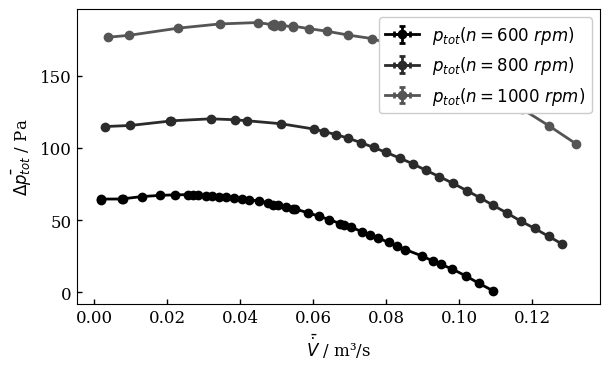

In [9]:
with plotting.SingleAxis(
        scale=1.0,
        filename="fan_curve_600_800_1000.svg",
) as dax:
    for fc in fan_curves_scaled:
        _n = fc.get_result_by_standard_name(iri=sn_mean_nrot)[0].hasNumericalVariable.hasNumericalValue
        fc.errorbar(
            x="arithmetic_mean_of_fan_volume_flow_rate",
            # y="arithmetic_mean_of_difference_of_static_pressure_between_fan_outlet_and_fan_inlet",
            y="arithmetic_mean_of_difference_of_total_pressure_between_fan_outlet_and_fan_inlet",
            xlabel=None,
            ylabel=None,
            label=f"$p_{{tot}} (n={_n}~rpm)$",
            marker=".",
            linestyle='-',
            ax=dax.ax,
            raise_on_no_data_points=False,
            verbose=True
        )
    plt.legend()
    plt.tight_layout()

Exporting the fan curve data to HDF5:

In [10]:
from ontolutils.utils.qudt_units import qudt_lookup
inverse_qudt_lookup = {str(v): k for k, v in qudt_lookup.items()}

In [11]:
df = db.get_fan_properties()

In [12]:
# from opencefadb.sparql_templates import get_properties

In [13]:
from opencefadb.models.fan_curve import get_result_by_standard_name

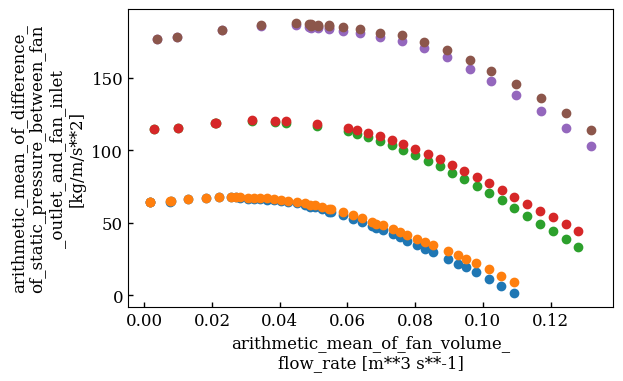

In [27]:
import h5rdmtoolbox as h5tbx
from rdflib.namespace import DCTERMS
from datetime import datetime

with h5tbx.File("fan_curves.hdf", "w") as h5:
    # first some metadata about the file:
    h5.attrs["creator", DCTERMS.creator] = "Matthias Probst" # replace with your name!
    h5.rdf["creator"].object = "https://orcid.org/0000-0001-8729-0482"
    h5.attrs["creation_date", DCTERMS.created] = datetime.now()
    
    g = h5.create_group("fan_properties")
    for idx, row in df.iterrows():
        parameter = row["parameter"]
        prop = row["property"]
        key = parameter.rsplit("#", 1)[-1]
        if key in g:
            gg = g[key]
        else:
            gg = g.create_group(key)
        value = row["value"]
        if prop.startswith("http"):
            prop = prop.rsplit("#")[-1]
        if isinstance(value, str) and value.startswith("https://doi.org/10.5281/zenodo.17271932#standard_names"):
            gg.attrs[prop] = value.rsplit("/")[-1]
        else:
            gg.attrs[prop] = value
    
    
    for i, _n in enumerate(rotation_speeds):

        # get data by standard name:
        mean_rho = fan_curves_scaled[i].get_result_by_standard_name(iri=sn_mean_rho)
        nrot = fan_curves_scaled[i].get_result_by_standard_name(iri=sn_mean_nrot)
        vfr = fan_curves_scaled[i].get_result_by_standard_name(iri=sn_mean_vfr)
        dpstat = fan_curves_scaled[i].get_result_by_standard_name(iri=sn_mean_dp_stat)
        dptot = fan_curves_scaled[i].get_result_by_standard_name(iri=sn_mean_dp_tot)

        g = h5.create_group(f"n{_n}")
        g.attrs["hasFeatureOfInterest", "http://www.w3.org/ns/sosa/hasFeatureOfInterest"] = fan_curves[i].collection.hasFeatureOfInterest
    
        data = [r.hasNumericalVariable.hasNumericalValue for r in nrot]
        g.create_dataset("nrot",
                         data=data,
                         make_scale=True,
                         attrs={
                             "symbol": nrot[i].hasNumericalVariable.hasSymbol,
                             "units": inverse_qudt_lookup.get(nrot[i].hasNumericalVariable.hasUnit, nrot[i].hasNumericalVariable.hasUnit),
                             # "standard_name": nrot[i].hasNumericalVariable.hasStandardName.standardName,
                         })
    
        data = [r.hasNumericalVariable.hasNumericalValue for r in vfr]
        g.create_dataset("vfr",
                         data=data,
                         make_scale=True,
                         attrs={
                             "symbol": vfr[i].hasNumericalVariable.hasSymbol,
                             "units": inverse_qudt_lookup.get(vfr[i].hasNumericalVariable.hasUnit.id, vfr[i].hasNumericalVariable.hasUnit),
                             "standard_name": vfr[i].hasNumericalVariable.hasStandardName.standardName,
                         })
        
        data = [r.hasNumericalVariable.hasNumericalValue for r in dptot]
        g.create_dataset("dptot",
                         data=data,
                         attach_scale=[[g.vfr, g.nrot],],
                          attrs={
                             "symbol": dptot[i].hasNumericalVariable.hasSymbol,
                             "units": inverse_qudt_lookup.get(dptot[i].hasNumericalVariable.hasUnit.id, dptot[i].hasNumericalVariable.hasUnit),
                             "standard_name": dptot[i].hasNumericalVariable.hasStandardName.standardName,
                          })
        
        data = [r.hasNumericalVariable.hasNumericalValue for r in dpstat]
        g.create_dataset("dpstat", data=data, attach_scale=g.vfr,
                         attrs={
                             "symbol": dpstat[i].hasNumericalVariable.hasSymbol,
                             "units": inverse_qudt_lookup.get(dptot[i].hasNumericalVariable.hasUnit.id, dptot[i].hasNumericalVariable.hasUnit),
                             "standard_name": dpstat[i].hasNumericalVariable.hasStandardName.standardName,
                         })

        data = [r.hasNumericalVariable.hasNumericalValue for r in mean_rho]
        g.create_dataset("mean_rho", data=data, attach_scale=[[g.vfr, g.nrot],],
                         attrs={"symbol": _mean_rho0.hasNumericalVariable.hasSymbol,
                                "units": _mean_rho0.hasNumericalVariable.hasUnit.id,
                                "standard_name": _mean_rho0.hasNumericalVariable.hasStandardName.standardName,
                               }
                        )
        
        g.dptot[()].plot(marker=".", linestyle="")
        g.dpstat[()].plot(marker=".", linestyle="")
        
    h5.dump()

In [28]:
n_rot = 600
observations_600 = db.get_operating_point_observations(
    n_rot_speed_rpm=n_rot,
    operating_point_standard_names=operating_point_standard_names,
    standard_name_of_rotational_speed=sn_mean_nrot,
    n_rot_tolerance=0.05 # 5 %
)

Processing operating point datasets: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:09<00:00,  4.60 datasets/s]


In [29]:
fan_curve_600 = SemanticFanCurve.from_observations(
    observations=observations_600
)

In [30]:
from ssnolib.m4i import NumericalVariable
from ontolutils.namespacelib import QUDT_KIND, QUDT_UNIT

In [31]:
NumericalVariable(
        has_numerical_value=600,
        has_unit=QUDT_UNIT.REV_PER_MIN,
        has_kind_of_quantity=QUDT_KIND.RotationalVelocity
    )

NumericalVariable(id=_:Nb01cc03e07c54a25812cbc074d4201c5, hasUnit=http://qudt.org/vocab/unit/REV-PER-MIN, hasKindOfQuantity=http://qudt.org/vocab/quantitykind/RotationalVelocity, hasNumericalValue=600)

In [32]:
fan_curve_600_scaled = fan_curve_600.scale(
    NumericalVariable(
        has_numerical_value=600,
        has_unit=QUDT_UNIT.REV_PER_MIN,
        has_kind_of_quantity=QUDT_KIND.RotationalVelocity
    )
)

 [OpenCEFA DB]: Obtaining plotting data...
 [OpenCEFA DB]: ... done.


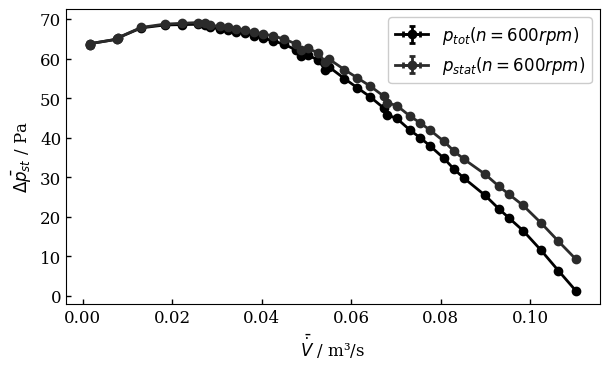

In [33]:
with plotting.SingleAxis(
        scale=1.0,
        filename="test_fan_curve.svg",
) as dax:
    fan_curve_600.errorbar(
        x="arithmetic_mean_of_fan_volume_flow_rate",
        # y="arithmetic_mean_of_difference_of_static_pressure_between_fan_outlet_and_fan_inlet",
        y="arithmetic_mean_of_difference_of_total_pressure_between_fan_outlet_and_fan_inlet",
        xlabel=None,
        ylabel=None,
        label="$p_{tot} (n=600 rpm)$",
        marker=".",
        linestyle='-',
        ax=dax.ax,
        verbose=True
    )
    fan_curve_600.errorbar(
        x="arithmetic_mean_of_fan_volume_flow_rate",
        y="arithmetic_mean_of_difference_of_static_pressure_between_fan_outlet_and_fan_inlet",
        xlabel=None,
        ylabel=None,
        label="$p_{stat} (n=600 rpm)$",
        marker=".",
        linestyle='-',
        ax=dax.ax,
    )
    plt.legend()
    plt.tight_layout()

## Serialization of fan curves

Since we model the operation points and fan curve semantically, we can serialize it as TTL in order to share it with others or machines.

In [34]:
ttl = fan_curve_600.serialize()

In [35]:
print(ttl)

@prefix m4i: <http://w3id.org/nfdi4ing/metadata4ing#> .
@prefix qudt: <http://qudt.org/schema/qudt/> .
@prefix sosa: <http://www.w3.org/ns/sosa/> .
@prefix ssno: <https://matthiasprobst.github.io/ssno#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<https://doi.org/10.5281/zenodo.17572275#standard_name_table/derived_standard_name/arithmetic_mean_of_air_density> a ssno:StandardName ;
    ssno:description "Derived standard name using transformation 'arithmetic_mean_of_X' (Arithmetic mean of the standard name.) applied to 'air_density'. air_density: Density is defined as the mass of air divided by its volume." ;
    ssno:standardName "arithmetic_mean_of_air_density" ;
    ssno:standardNameTable <https://doi.org/10.5281/zenodo.17572275#standard_name_table> ;
    ssno:unit <http://qudt.org/vocab/unit/KiloGM-PER-M3> .

<https://doi.org/10.5281/zenodo.17572275#standard_name_table/derived_standard_name/arithmetic_mean_of_difference_of_static_pressure_between_fan_outlet_and_fan_inlet> a